#Univariate LSTM predicting next value on the basis of past market values

Dependencies

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf, random
import mysql.connector

Connect to DB and load data

In [186]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="yahoonet",
    database="AIProject"
)

df = pd.read_sql("SELECT * FROM player_features", db)


print("✅ Loaded player_features shape:", df.shape)
df.head()

✅ Loaded player_features shape: (1305, 22)


C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_22212\3046130896.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM player_features", db)


,player_id,latest_market_value,market_value_growth,total_injuries,avg_days_out,last_injury_date,total_transfers,total_transfer_fees,free_transfers,sentiment_mean,...,avg_cards_per_match,positions_played,current_club_id,primary_position,recent_injury,days_since_last_injury,season_id,minutes_played,shots_per90,pressures_per90
0,7492,0.0,0.0,6,87.1667,2016-03-12,3.0,1300000.0,0.0,0.059179,...,0.0,Right Defensive Midfield,4351,Right Defensive Midfield,0,3418,0,90,0.00000,40.0000
1,8198,100000000.0,100000000.0,29,16.6207,2025-05-11,12.0,247002000.0,1.0,0.096791,...,0.0,"Center Defensive Midfield, Center Forward, Lef...",613,Left Wing,1,126,0,180,4.50000,11.5000
2,18922,29000000.0,29000000.0,43,16.5581,2025-05-11,5.0,35000000.0,1.0,0.124165,...,0.0,"Center Attacking Midfield, Center Forward, Lef...",920,Center Forward,1,123,0,180,4.00000,8.0000
3,28396,30000000.0,30000000.0,16,14.4375,2023-12-17,12.0,54880000.0,2.0,0.091928,...,0.0,"Center Attacking Midfield, Center Defensive Mi...",544,Center Forward,0,640,0,1890,4.19048,14.5238
4,33812,2500000.0,2500000.0,2,73.0000,2014-08-13,11.0,250000.0,4.0,0.074747,...,0.0,,0,,0,0,0,0,0.00000,0.0000


EDA
 - Missing values

In [187]:
print(df.isnull().sum())

player_id                    0
latest_market_value         87
market_value_growth         87
total_injuries               0
avg_days_out                 0
last_injury_date            87
total_transfers             87
total_transfer_fees         87
free_transfers              87
sentiment_mean               0
sentiment_positive_ratio     0
sentiment_trend              0
avg_cards_per_match          0
positions_played             0
current_club_id              0
primary_position             0
recent_injury                0
days_since_last_injury       0
season_id                    0
minutes_played               0
shots_per90                  0
pressures_per90              0
dtype: int64


Histograms of key features

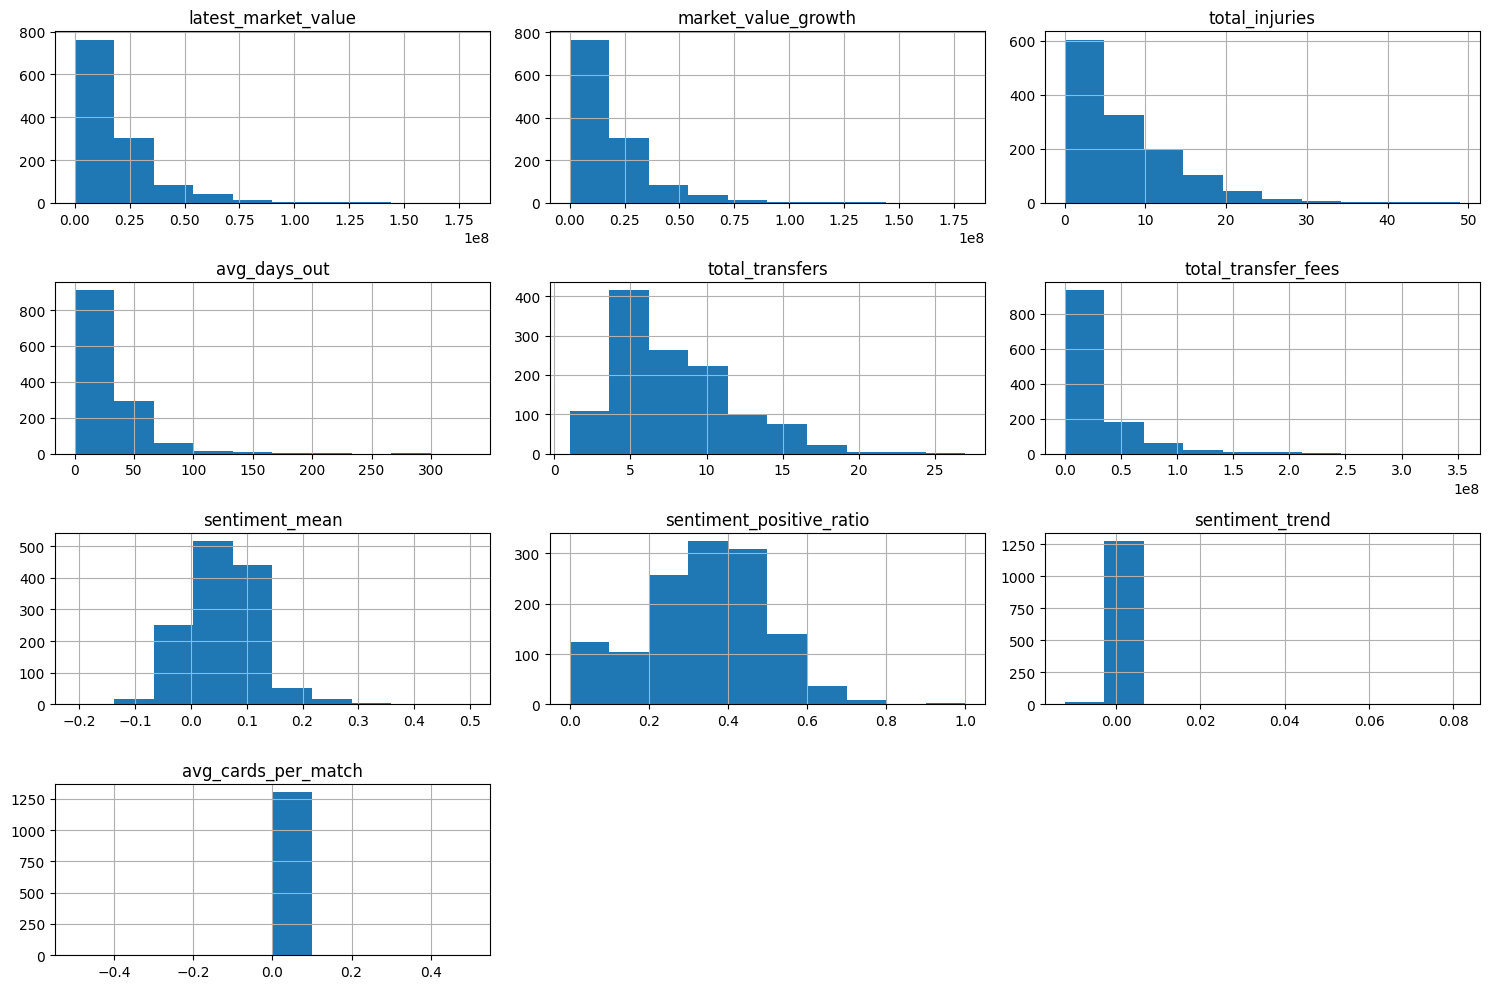

In [188]:
num_cols = ["latest_market_value", "market_value_growth",
            "total_injuries", "avg_days_out",
            "total_transfers", "total_transfer_fees",
            "sentiment_mean", "sentiment_positive_ratio",
            "sentiment_trend", "avg_cards_per_match"]
df[num_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

Correlation heatmap

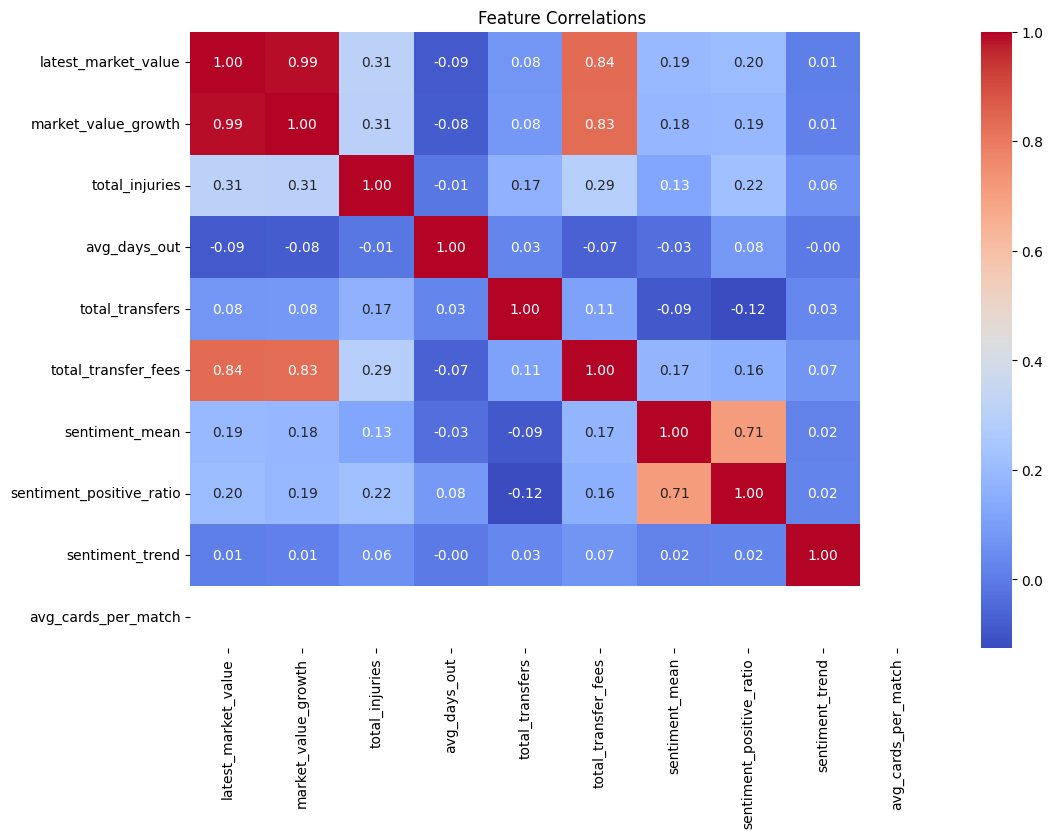

In [189]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

Define a function to convert one player’s series into (X, y) samples:

In [190]:
def make_sequences(series, n_steps=3):
    """Given a 1D array, return X,y arrays of sliding windows"""
    X, y = [], []
    for i in range(len(series)-n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)


Prepare Univariate Time Series
# =======================================
# Here we simulate with random time series for one player_id

In [191]:

#player_id = df['player_id'].iloc[0]
player_id = 28396  # Example player_id with time series data
print(f"Using player_id: {player_id} for univariate LSTM demo.")


Using player_id: 28396 for univariate LSTM demo.


market_values = [list of values over time]

In [192]:
#market_values = np.array([10, 12, 15, 14, 17, 20, 23, 22, 25], dtype=float).reshape(-1, 1)
#mv_df = pd.read_sql(f"SELECT * FROM player_transfer_history where market_value>0 and transfermarkt_id={player_id} order by transfer_date", db)
mv_df = pd.read_sql(f"SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history WHERE market_value IS NOT NULL ORDER BY transfermarkt_id, transfer_date", db)

print(f"Loaded market value history shape: {mv_df.shape}")
mv_df = mv_df.sort_values(by='transfer_date')
print(mv_df.head())

#market_values = mv_df['market_value'].values.reshape(-1, 1)
#print(f"Market values time series shape: {market_values.shape}")

#db.close()
#market_values=np.a
n_steps = 3  # how many past windows to use
scaler = MinMaxScaler()
X_list, y_list = [], []
player_index = []  # keep track of which player each sample belongs to
for pid, group in mv_df.groupby("transfermarkt_id"):
    values = group["market_value"].values.reshape(-1,1)
    scaled = scaler.fit_transform(values)  # scale per player
    
    Xp, yp = make_sequences(scaled, n_steps)
    if len(Xp) == 0:  # skip players with too few points
        continue
    X_list.append(Xp)
    y_list.append(yp)
    player_index.extend([pid]*len(yp))

X = np.vstack(X_list)                # shape: (total_samples, n_steps, 1)
y = np.concatenate(y_list)           # shape: (total_samples, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))


#market_values_scaled = scaler.fit_transform(market_values)

Loaded market value history shape: (9558, 3)
   transfermarkt_id transfer_date  market_value
3              8198    1995-07-01             0
0              7492    1996-07-01             0
4              8198    1996-07-01             0
5              8198    1997-07-01             0
1              7492    1998-07-01             0


C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_22212\3999914728.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mv_df = pd.read_sql(f"SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history WHERE market_value IS NOT NULL ORDER BY transfermarkt_id, transfer_date", db)


Build sequences: use past 3 steps to predict next step

In [193]:
def create_sequences(data, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i+time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(market_values_scaled, time_steps=3)
X = X.reshape((X.shape[0], X.shape[1], 1))  # [samples, timesteps, features]

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (5, 3, 1) y shape: (5,)


Build and Train LSTM

In [194]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    LSTM(32, input_shape=(n_steps,1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=50, batch_size=32, shuffle=False, validation_split=0.1)

"""
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = model.fit(X, y, epochs=100, verbose=1, callbacks=[early_stop])
"""

Epoch 1/50


C:\Users\Himanshu Saxena\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0994 - val_loss: 1.9220e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0940 - val_loss: 4.2409e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0889 - val_loss: 7.4514e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0840 - val_loss: 0.0012
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0793 - val_loss: 0.0016
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0748 - val_loss: 0.0022
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0706 - val_loss: 0.0029
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0665 - val_loss: 0.0036
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0627 - val_loss: 0.0045
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0591 - val_loss: 0.0054
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0557 - val_loss: 0.0064
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0525 - val_loss: 0.0074
Ep

"\nmodel = Sequential()\nmodel.add(LSTM(50, activation='tanh', input_shape=(X.shape[1], 1)))\nmodel.add(Dense(1))\nmodel.compile(optimizer='adam', loss='mse')\n\nearly_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)\n\nhistory = model.fit(X, y, epochs=100, verbose=1, callbacks=[early_stop])\n"

Plot training loss

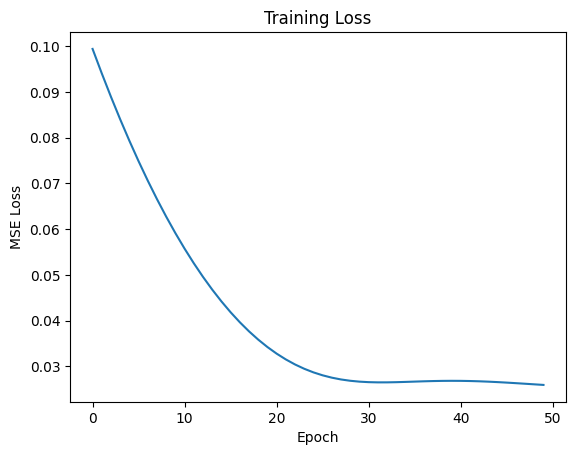

In [195]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

Predict the next market value step

In [196]:
"""
last_seq = market_values_scaled[-3:].reshape((1, 3, 1))
pred_scaled = model.predict(last_seq)
pred = scaler.inverse_transform(pred_scaled)
print("Next predicted market value:", format(pred[0][0], '.2f'))
"""
pid = 28396
series = mv_df[mv_df.transfermarkt_id==pid]["market_value"].values.reshape(-1,1)
scaled = scaler.fit_transform(series)
last_seq = scaled[-n_steps:].reshape(1, n_steps, 1)

pred_scaled = model.predict(last_seq)
pred_value = scaler.inverse_transform(pred_scaled)[0][0]
print("Predicted next market value for player", pid, "=", format(pred_value,'.2f'))

db.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted next market value for player 28396 = 4557603.50
